# Extracting data from a plot
There is an interesting article from Google, titled [Availability in Globally Distributed Storage Systems](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/36737.pdf) from Google. Figure 8 on page 6 shows the counts of events affecting certain number of racks and nodes, see below:
<figure>
<img src="events.png" alt="Trulli" style="width:100%">
<figcaption align = "center"><b>Figure 1:  Frequency of failure bursts sorted by racks and nodes
affected.</b></figcaption>
</figure>

Unfortunately the data for the plot is not available, and we want to extract the data from the plot by processing the image.

## Loading the image and calibration
This is the part to load the image and understand the $x$ and $y$ offsets and scales. There are a few parameters we adjust to fix the origin and the scales. One thing to notice is that the pixel coordinates start from the left top and increases towards the bottom/right. So the $y$ coordinate in the usual sense, i.e. increasing from bottom to top, is flipped with respect to the pixel index. 

We will use a built in function available in PIL to draw circles on the image.

In [44]:
from PIL import Image, ImageDraw
import math
import matplotlib.pyplot as plt
import numpy as np
imgPath=""
imgid= 'events.png' # taken from https://docs.google.com/presentation/d/1onHMsDkEARxagluUmHHS2as6YPWWAyDO/edit?rtpof=true&sd=true

img = Image.open(imgPath+imgid)

pixels = img.load()
#calibrate these values to match the origin, xrange and aspect ratio
cx=110
cy=img.size[1]-705
xrange= img.size[0]
aspectR=0.895


def calib(x):
    tv=x -cx
    vv=   img.size[1]-tv*aspectR   -cy
    return  vv

def drawC(draw,thisCircle,colorIn): # draw is the object, thisCircle=[xc,yc,radius]
    leftUpPoint = (thisCircle[0]-thisCircle[2], thisCircle[1]-thisCircle[2])
    rightDownPoint = (thisCircle[0]+thisCircle[2], thisCircle[1]+thisCircle[2])
    draw.ellipse([leftUpPoint, rightDownPoint],  outline =colorIn)

for i in range(cx,xrange): # draw a line. This should connect (0,0) with (x_max, y_max) if the calibration was done properly
    for j in range(3):
            h=  calib(i)+j
            if 1<h< img.size[1]:
             pixels[i,h ] = (0, 0,255)
img.save('calibration_'+imgid)
#draw = ImageDraw.Draw(img)

<figure>
<img src="calibration_events.png" alt="Trulli" style="width:100%">
<figcaption align = "center"><b>Figure 2: Calibration of the origin and scales. The line should connect (0,0) with (x_max, y_max) if the calibration was done properly </b></figcaption>
</figure>

## Extracting the occurance scale from the legend
The conversion from the circle radius to number of occurences is done by the scales given in the legend. We first need to analyze the legend and extract the radii.

In [45]:
img = Image.open(imgPath+imgid)
draw = ImageDraw.Draw(img)
scaleCircles = [[666,651,38,1000],[666,569,26,100],[666,487,14,10],[666,406,2.5,1]] # this list is created manually and iteratively

sOccuranceL=[]
sOccurance=[]
sRadius=[]

for scaleCircle in scaleCircles:
    drawC(draw,scaleCircle,'red')
    sOccuranceL.append(math.log10(scaleCircle[3]) )
    sOccurance.append(scaleCircle[3] )
    sRadius.append(scaleCircle[2])
img.save('scales_'+imgid)


<figure>
<img src="scales_events.png" alt="Trulli" style="width:100%">
<figcaption align = "center"><b>Figure 3: Overlaying red circles on the legend entries. </b></figcaption>
</figure>

Let's fit a line to the radii to get a continuos map from circle radius to the occurence count.

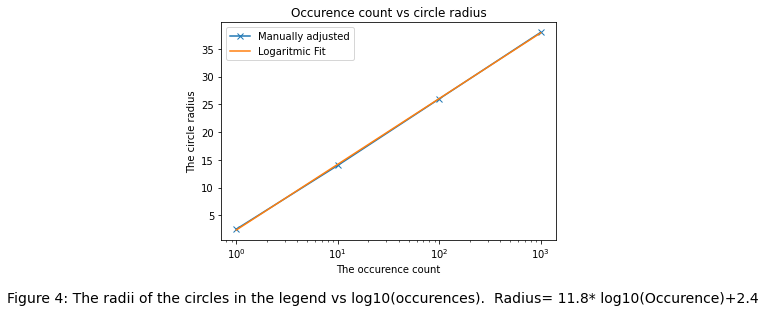

In [26]:
# fit a line to the log(Occurence) vs radii scales to find the formula for the mapping
m, b = np.polyfit(sOccuranceL,sRadius , 1)
sOccuranceLF=[]
sRadiusF=[]
for sOcc in sOccuranceL: ## calculate the fitted valued
      sRadiusF.append(   sOcc*m+b   )



plt.plot(sOccurance,sRadius, label='Manually adjusted', marker='x')
plt.plot(sOccurance,sRadiusF, label='Logaritmic Fit'   )
plt.xlabel('The occurence count')
plt.xscale("log")
plt.ylabel('The circle radius')
plt.title('Occurence count vs circle radius')
plt.legend()
txt="Figure 4: The radii of the circles in the legend vs log10(occurences).  Radius= "+ str(m.round(1))+"* log10(Occurence)+"+ str(b.round(1))
plt.figtext(0.5, -0.09, txt, wrap=True, horizontalalignment='center', fontsize=14);
plt.show()

The radii of the four circles in the legend sit perfectly on a line.

We should be able to calculate the occurence counts corresponding to the circles inside the plot with minimal error.

## Calculating the radius for the circles on the plot
We certainly don't want to manually compute the radii for all the circles in the plot. We want to find the underlying trends as $x$ and $y$ axis values change and do some fitting. Let's look at the circles at $x=1$, i.e., Number of racks affected=1.

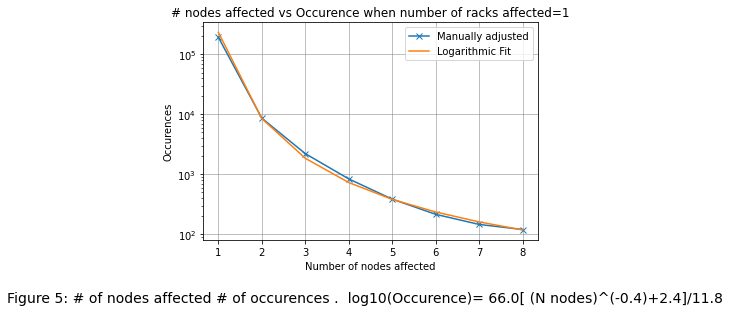

In [42]:
oneCircles = [[139,681,65,1],[139,607,49,2],[139,564,42,3],[139,534,37,4],[139,510,33,5],[139,492,30,6],[139,475,28,7],[139,461,27,8]] #manual work
nNodes=[]
nNodesL=[]
oneRadiiL=[]
logEvents=[]
Events=[]
oneRadii=[]
for Circle in oneCircles:
    nNodes.append(Circle[3] )
    nNodesL.append(math.log10(Circle[3] )  )
    #drawC(draw,Circle,'blue')
    oneRadii.append(Circle[2])
    oneRadiiL.append(math.log10(Circle[2] ))
    logEvents.append( (Circle[2]-b)/m)
    Events.append(   10**((Circle[2]-b)/m )  )
#img.show()


one_mL, one_bL = np.polyfit(nNodesL,oneRadiiL, 1)

oneRadiiLF=[]
oneRadiiF=[]
EventsF=[]
EventsFull=[]
for this in nNodesL:
      thisN=10**this
      thisR=10**(this*one_mL+one_bL)
      oneRadiiF.append(  thisR  )
      EventsF.append(   10**((thisR-b)/m )  )
      EventsFull.append(  10**((thisN**one_mL*10**one_bL-b)/m))   # this is the full expression after eliminating R

thefrm=str((10**one_bL).round(1))+"[ (N nodes)^("+str(one_mL.round(1))+")"+"+"+str(b.round(1))+"]/"+str(m.round(1))
plt.plot(nNodes,  Events, label='Manually adjusted', marker='x')
#plt.plot(nNodes,  EventsF, label='Logarithmic Fit')
plt.plot(nNodes,  EventsFull, label='Logarithmic Fit')

plt.xlabel('Number of nodes affected')
plt.ylabel('Occurences')
plt.title('# nodes affected vs Occurence when number of racks affected=1')
plt.yscale("log")
plt.legend()
plt.grid(color='gray', linestyle='-', linewidth=0.5)
txt="Figure 5: # of nodes affected # of occurences .  log10(Occurence)= "+thefrm
plt.figtext(0.5, -0.09, txt, wrap=True, horizontalalignment='center', fontsize=14);
plt.show()



The formula looks complicated because it is a union of two maps. One from number of nodes to radius, and the second is from the radius to occurence count. We now take the first part of the formula and create circles in a loop and put them in the plot to see how well they aling with the original ones.

In [58]:
def yloc(theindex): # estimating the y coordinate of the center of the circles
    y1=681;y2=607; delta=y1-y2
    yval=y1-math.log10(theindex)*delta /math.log10(2)
    return yval


def xloc(theindex):  # estimating the x coordinate of the center of the circles
    x1=139;x2=221; delta=x2-x1
    xval=x1+math.log10(theindex)*delta /math.log10(2)
    return xval

def predictRone(theindex):

    return 10** (math.log10(theindex)*one_mL+one_bL)


for n in range(1,20):
    Circle=[139,yloc(n),predictRone(n)]
    #print(Circle)
    drawC(draw,Circle,'red')
    
img.save('firstcircles_'+imgid)    

<figure>
<img src="firstcircles_events.png" alt="Trulli" style="width:100%">
<figcaption align = "center"><b>Figure 6: Overlaying red circles on the first stack of circles. </b></figcaption>
</figure>

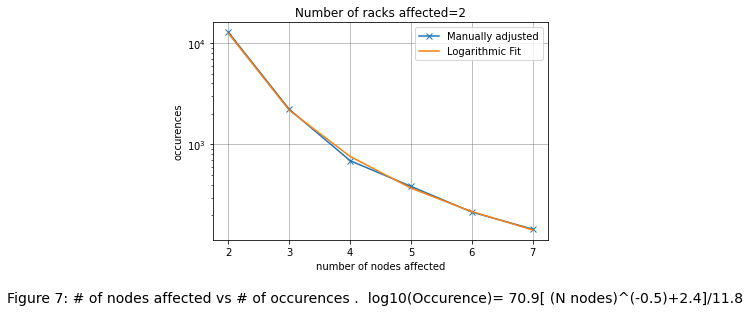

In [46]:
twoCircles = [[221,607,51,2],[221,564,42,3],[221,534,36,4],[221,511,33,5],[221,491,30,6],[221,475,28,7]]   #,[221,461,26,7],[221,370,18,18]   ,[221,461,26,6],[221,450,25,7]

twoNodesL=[]
twoRadiiL=[]

twoNodes=[]
twoRadii=[]
twoEvents=[]

for Circle in twoCircles:
    #drawC(draw,Circle,'green')
    twoNodes.append(Circle[3])
    twoNodesL.append(math.log10(Circle[3]) )
    twoRadii.append(Circle[2])
    twoRadiiL.append(math.log10(Circle[2]) )
    twoEvents.append(   10**((Circle[2]-b)/m )  )

two_mL, two_bL = np.polyfit(twoNodesL,twoRadiiL, 1)

twoRadiiLF=[]
twoRadiiF=[]
twoEventsF=[]
for this in twoNodesL:
      twoRadiiLF.append(   this*two_mL+two_bL   )
      twoRadiiF.append(  10** (this*two_mL+two_bL)   )
      thisN=10**this
      thisR=10**(this*two_mL+two_bL)
      twoEventsF.append(   10**((thisR-b)/m )  )


plt.plot(twoNodes,twoEvents, label='Manually adjusted', marker='x')
plt.plot(twoNodes, twoEventsF, label='Logarithmic Fit')

twofrm=str((10**two_bL).round(1))+"[ (N nodes)^("+str(two_mL.round(1))+")"+"+"+str(b.round(1))+"]/"+str(m.round(1))

plt.xlabel('number of nodes affected')
plt.ylabel('occurences')
plt.title('Number of racks affected=2')
plt.yscale("log")
plt.legend()
plt.grid(color='gray', linestyle='-', linewidth=0.5)
txt="Figure 7: # of nodes affected vs # of occurences .  log10(Occurence)= "+twofrm
plt.figtext(0.5, -0.09, txt, wrap=True, horizontalalignment='center', fontsize=14);
plt.show()


Lets again create circles in a loop and put them in the plot at the second stack to see how well they aling with the original ones.

In [36]:
def predictRtwo(theindex):

    return 10** (math.log10(theindex)*two_mL+two_bL)
for n in range(2,20):
    Circle=[221,yloc(n),predictRtwo(n)]
    #print(Circle)
    drawC(draw,Circle,'green')
img.save('secondcircles_'+imgid)    

<figure>
<img src="secondcircles_events.png" alt="Trulli" style="width:100%">
<figcaption align = "center"><b>Figure 8: Overlaying green circles on the second stack of circles. </b></figcaption>
</figure>

Repeat for the last time for the third stack

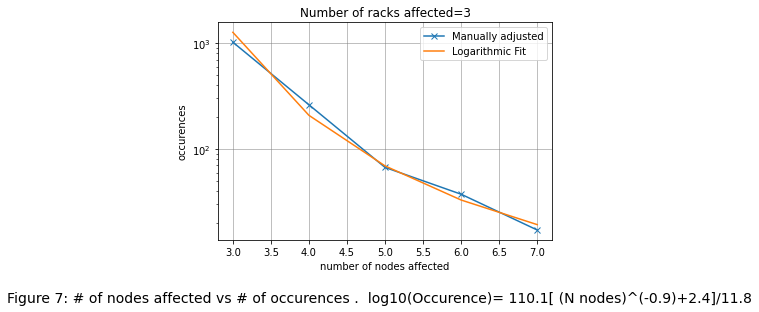

In [47]:
threeCircles = [[269, 565, 38,3], [269, 534.0, 31,4], [269, 510, 24,5], [269, 491, 21,6], [269, 474, 17,7]]

threeNodesL=[]
threeRadiiL=[]

threeNodes=[]
threeRadii=[]
threeEvents=[]

for Circle in threeCircles:
    #drawC(draw,Circle,'blue')
    threeNodes.append(Circle[3])
    threeNodesL.append(math.log10(Circle[3]) )
    threeRadii.append(Circle[2])
    threeRadiiL.append(math.log10(Circle[2]) )
    threeEvents.append(   10**((Circle[2]-b)/m )  )



three_mL, three_bL = np.polyfit(threeNodesL,threeRadiiL, 1)

threeRadiiLF=[]
threeRadiiF=[]
threeEventsF=[]
for this in threeNodesL:
      threeRadiiLF.append(   this*three_mL+three_bL   )
      threeRadiiF.append(  10** (this*three_mL+three_bL)   )
      thisN=10**this
      thisR=10**(this*three_mL+three_bL)
      threeEventsF.append(   10**((thisR-b)/m )  )
        
plt.plot(threeNodes,threeEvents, label='Manually adjusted', marker='x')
plt.plot(threeNodes, threeEventsF, label='Logarithmic Fit')

threefrm=str((10**three_bL).round(1))+"[ (N nodes)^("+str(three_mL.round(1))+")"+"+"+str(b.round(1))+"]/"+str(m.round(1))

plt.xlabel('number of nodes affected')
plt.ylabel('occurences')
plt.title('Number of racks affected=3')
plt.yscale("log")
plt.legend()
plt.grid(color='gray', linestyle='-', linewidth=0.5)
txt="Figure 9: # of nodes affected vs # of occurences .  log10(Occurence)= "+threefrm
plt.figtext(0.5, -0.09, txt, wrap=True, horizontalalignment='center', fontsize=14);
plt.show()        

In [38]:
def predictRthree(theindex):

    return 10** (math.log10(theindex)*three_mL+three_bL)
for n in range(3,15):
    Circle=[269,yloc(n)+1,predictRthree(n)]
    drawC(draw,Circle,'blue')
img.save('thirdcircles_'+imgid)        

<figure>
<img src="thirdcircles_events.png" alt="Trulli" style="width:100%">
<figcaption align = "center"><b>Figure 8: Overlaying blue circles on the third stack of circles. </b></figcaption>
</figure>

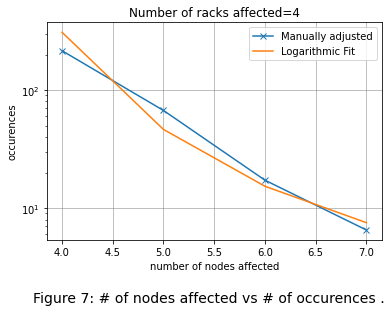

In [54]:
fourCircles=[]
thisi=4
fourCircles.append([xloc(4),yloc(thisi)+2,30,thisi])
thisi=5
fourCircles.append([xloc(4),yloc(thisi)+2,24,thisi])
thisi=6
fourCircles.append([xloc(4),yloc(thisi)+2,17,thisi])
thisi=7
fourCircles.append([xloc(4),yloc(thisi)+2,12,thisi])

fourNodesL=[]
fourRadiiL=[]

fourNodes=[]
fourRadii=[]
fourEvents=[]
for Circle in fourCircles:
    drawC(draw,Circle,'orange')
    fourNodes.append(Circle[3])
    fourNodesL.append(math.log10(Circle[3]) )
    fourRadii.append(Circle[2])
    fourRadiiL.append(math.log10(Circle[2]) )
    fourEvents.append(   10**((Circle[2]-b)/m )  )
four_mL, four_bL = np.polyfit(fourNodesL,fourRadiiL, 1)

fourRadiiLF=[]
fourRadiiF=[]
fourEventsF=[]
for this in fourNodesL:
      fourRadiiLF.append(   this*four_mL+four_bL   )
      fourRadiiF.append(  10** (this*four_mL+four_bL)   )
      thisN=10**this
      thisR=10**(this*four_mL+four_bL)
      fourEventsF.append(   10**((thisR-b)/m )  )

plt.plot(fourNodes,fourEvents, label='Manually adjusted', marker='x')
plt.plot(fourNodes, fourEventsF, label='Logarithmic Fit')


plt.xlabel('number of nodes affected')
plt.ylabel('occurences')
plt.title('Number of racks affected=4')
plt.yscale("log")
plt.legend()
plt.grid(color='gray', linestyle='-', linewidth=0.5)
txt="Figure 10: # of nodes affected vs # of occurences ."
plt.figtext(0.5, -0.09, txt, wrap=True, horizontalalignment='center', fontsize=14);
plt.show() 


In [59]:
def predictRfour(theindex):
     return 10** (math.log10(theindex)*four_mL+four_bL)

for n in range(4,10):
    Circle=[xloc(4),yloc(n),predictRfour(n)]
    drawC(draw,Circle,'blue')
    #print(Circle)
img.save('fourthcircles_'+imgid) 

[303.0, 533.0, 31.846427857756357]
[303.0, 509.17732097833516, 22.096355761239607]
[303.0, 489.71277494663445, 16.3915706910404]
[303.0, 473.2557357677373, 12.73387884950622]
[303.0, 459.0, 10.232200097351482]
[303.0, 446.4255498932689, 8.43685172225479]


<figure>
<img src="fourthcircles_events.png" alt="Trulli" style="width:100%">
<figcaption align = "center"><b>Figure 11: Overlaying blue circles on the third stack of circles. </b></figcaption>
</figure>

In [107]:
fiveCircles=[]
thisi=5
fiveCircles.append([xloc(5),yloc(thisi)+2,25,thisi])
thisi=6
fiveCircles.append([xloc(5),yloc(thisi)+2,18,thisi])
thisi=7
fiveCircles.append([xloc(5),yloc(thisi)+2,15,thisi])
thisi=8
fiveCircles.append([xloc(5),yloc(thisi)+2,11,thisi])

fiveNodesL=[]
fiveRadiiL=[]

fiveNodes=[]
fiveRadii=[]
fiveEvents=[]
for Circle in fiveCircles:
    drawC(draw,Circle,'green')
    fiveNodes.append(Circle[3])
    fiveNodesL.append(math.log10(Circle[3]) )
    fiveRadii.append(Circle[2])
    fiveRadiiL.append(math.log10(Circle[2]) )
    fiveEvents.append(   10**((Circle[2]-b)/m )  )
five_mL, five_bL = np.polyfit(fiveNodesL,fiveRadiiL, 1)

fiveRadiiLF=[]
fiveRadiiF=[]
fiveEventsF=[]
for this in fiveNodesL:
      fiveRadiiLF.append(   this*five_mL+five_bL   )
      fiveRadiiF.append(  10** (this*five_mL+five_bL)   )
      thisN=10**this
      thisR=10**(this*five_mL+five_bL)
      fiveEventsF.append(   10**((thisR-b)/m )  )

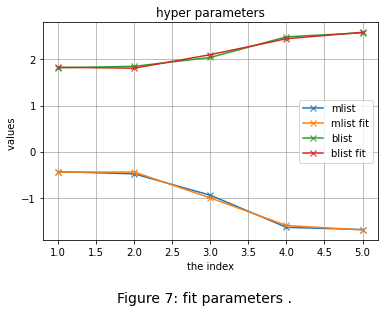

[-0.4313770209670292, -0.4791593263410262, -0.942160292578544, -1.6380151752448433, -1.685605877726082]
[-0.44135921171244186, -0.4392305633593623, -1.002053437051037, -1.5980864122631766, -1.6955880684714921]
[1.8194291455797487, 1.85066155247843, 2.0417378553908883, 2.489244127770171, 2.576824185187713]
[1.8296140349780563, 1.8099219948851935, 2.10284719178074, 2.4485045701769357, 2.587009074586022]


In [115]:
#one_mL, one_bL
indexer=range(1,6)
mlist=[one_mL,two_mL,three_mL,four_mL,five_mL]
blist=[one_bL,two_bL,three_bL,four_bL,five_bL]
hyper_mL_c,hyper_mL_q,hyper_mL_m, hyper_mL_b = np.polyfit(indexer,mlist, 3)
hyper_mL=[]
for this in indexer:
      hyper_mL.append(  this**3*hyper_mL_c +this**2*hyper_mL_q+this*hyper_mL_m+hyper_mL_b  )
        
hyper_bL_c,hyper_bL_q,hyper_bL_m, hyper_bL_b = np.polyfit(indexer,blist, 3)
hyper_bL=[]
for this in indexer:
      hyper_bL.append(   this**3*hyper_bL_c+ this**2*hyper_bL_q+this*hyper_bL_m+hyper_bL_b  )        


plt.plot(indexer,mlist, label='mlist', marker='x')
plt.plot(indexer,hyper_mL, label='mlist fit', marker='x')
plt.plot(indexer, blist, label='blist', marker='x')
plt.plot(indexer, hyper_bL, label='blist fit', marker='x')


plt.xlabel('the index')
plt.ylabel('values ')
plt.title('hyper parameters')
#plt.yscale("log")
plt.legend()
plt.grid(color='gray', linestyle='-', linewidth=0.5)
txt="Figure 12: fit parameters ."
plt.figtext(0.5, -0.09, txt, wrap=True, horizontalalignment='center', fontsize=14);
plt.show() 

print(mlist)
print(hyper_mL)
print(blist)
print(hyper_bL)


In [125]:

img = Image.open(imgPath+imgid)
draw = ImageDraw.Draw(img)

xmax=100
indexer=range(1,xmax)
print(indexer)

hyper_mL=[]
for this in indexer:
      hyper_mL.append(  this**3*hyper_mL_c +this**2*hyper_mL_q+this*hyper_mL_m+hyper_mL_b  )
        
hyper_bL=[]
for this in indexer:
      hyper_bL.append(   this**3*hyper_bL_c+ this**2*hyper_bL_q+this*hyper_bL_m+hyper_bL_b  )        

xmax=100
ymax=xmax
for indexx in range(0,xmax):
    for indexy in range(indexx,ymax):
        indexxC=indexx
        if indexx>4:
            indexxC=4
        theM=hyper_mL[indexxC]; theB=hyper_bL[indexxC]; theR=10** (math.log10(indexy+1)*theM+theB)
        #print ("x:"+str(indexx)+", y:"+str(indexy)+ ", ml="+str(theM)+", bl= "+str(theB))
        Circle=[xloc(indexx+1),yloc(indexy+1), theR]
        #print(Circle)
        drawC(draw,Circle,'blue')
img.save('allcircles_'+imgid)         
    
    


range(1, 100)


<figure>
<img src="allcircles_events.png" alt="Trulli" style="width:100%">
<figcaption align = "center"><b>Figure 13: Overlaying blue circles on the third stack of circles. </b></figcaption>
</figure>


In [157]:
plt.style.use('seaborn-white')
xmax=10
x_space = np.linspace(1,xmax,xmax)
y_space = np.linspace(1,xmax,xmax)

X,Y = np.meshgrid(x_space,y_space)
J = np.zeros((len(x_space),len(y_space)))
totalnum=0
for i in range(0,len(x_space)):
    for j in range(0,len(y_space)):
        indexxC=i
        if i>4:
            indexxC=4
        if j>=i: 
            theM=hyper_mL[indexxC]; theB=hyper_bL[indexxC]; theR=10** (math.log10(j+1)*theM+theB)
            #print ("x:"+str(i)+", y:"+str(j)+ ", ml="+str(theM)+", bl= "+str(theB)+", r="+str(theR))
            eventC=10**((theR-b)/m ) 
            J[i,j] =eventC.round(0)
            totalnum=totalnum+J[i,j]
        else:
           J[i,j]= 0 #float("nan")

Jn=J/totalnum
#print(J/totalnum)
print(totalnum)

np.savetxt("normalized_prob.csv", Jn, delimiter=",")

344371.0
